In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Softmax, CrossEntropyLoss, Module
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [2]:
# Creating Circuit

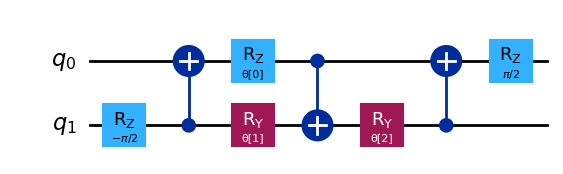

In [3]:
# Two qubit unitary as defined
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

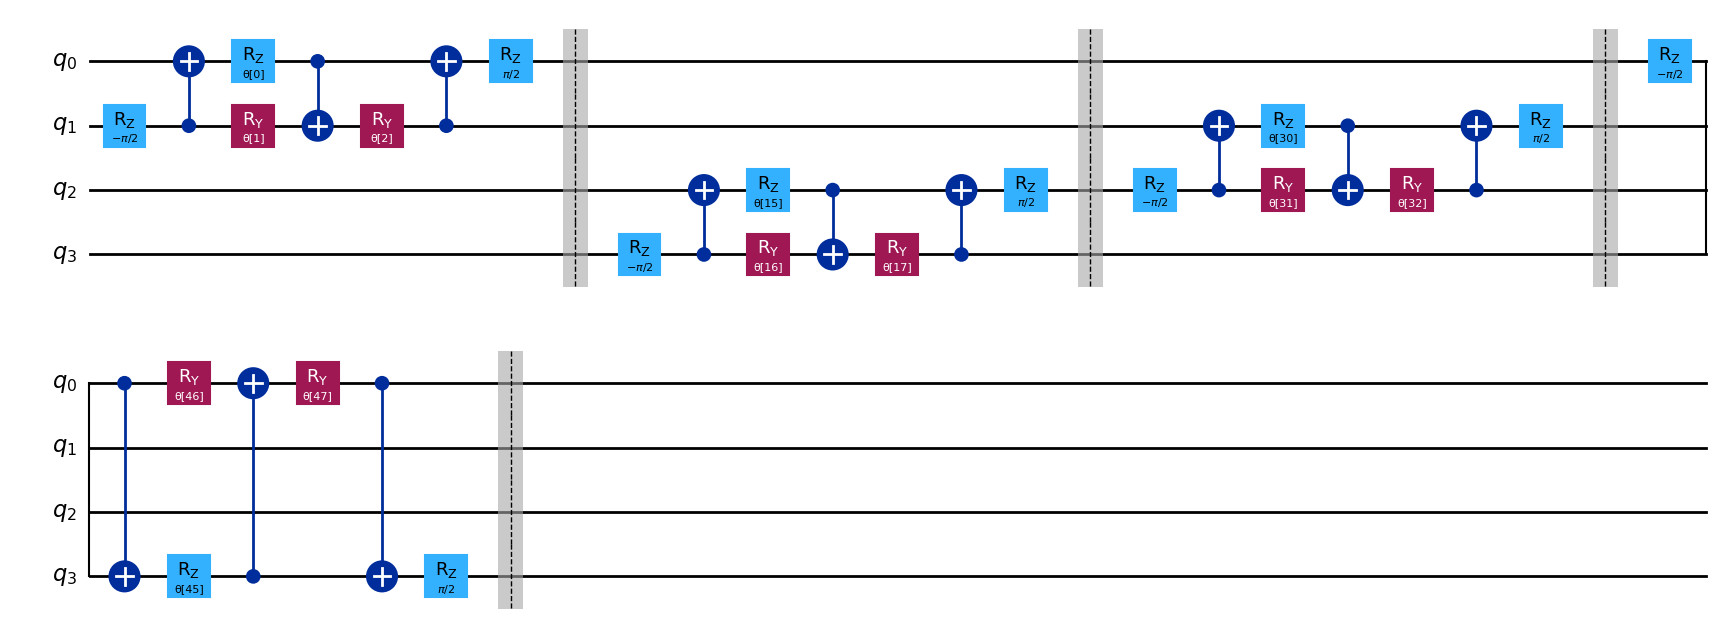

In [4]:
# Create Layer (Repeating Circuit on Neighboring Qubits).
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Visual
circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

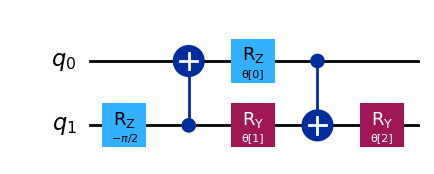

In [5]:
# Defining Pool Circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

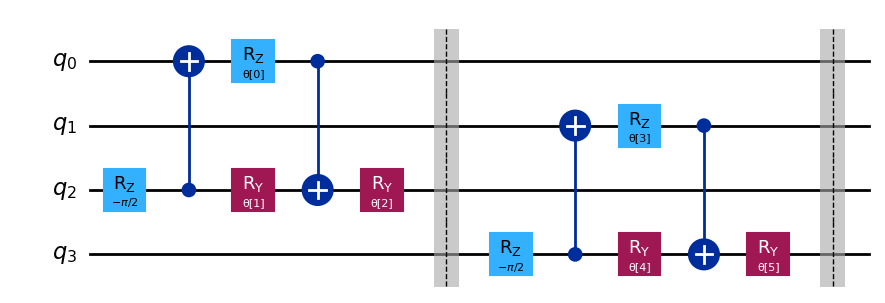

In [6]:
# Defining Pool Layer (Repeating Circuit on Neighboring Qubits)
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Visual
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

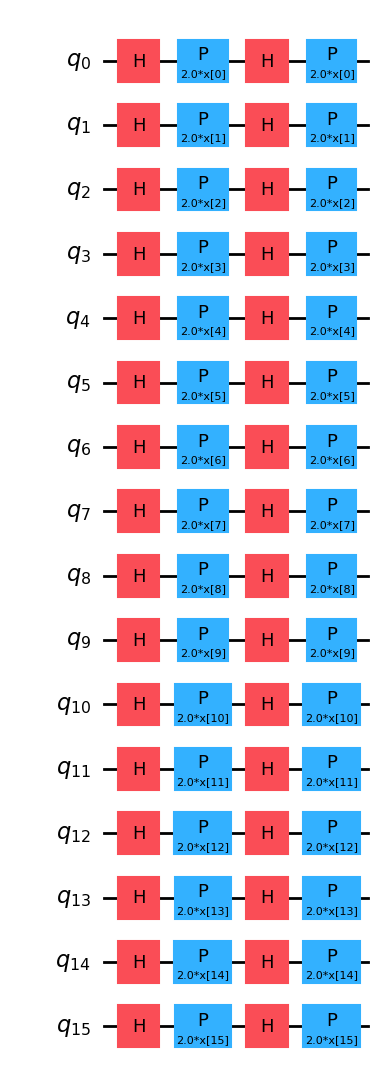

In [7]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

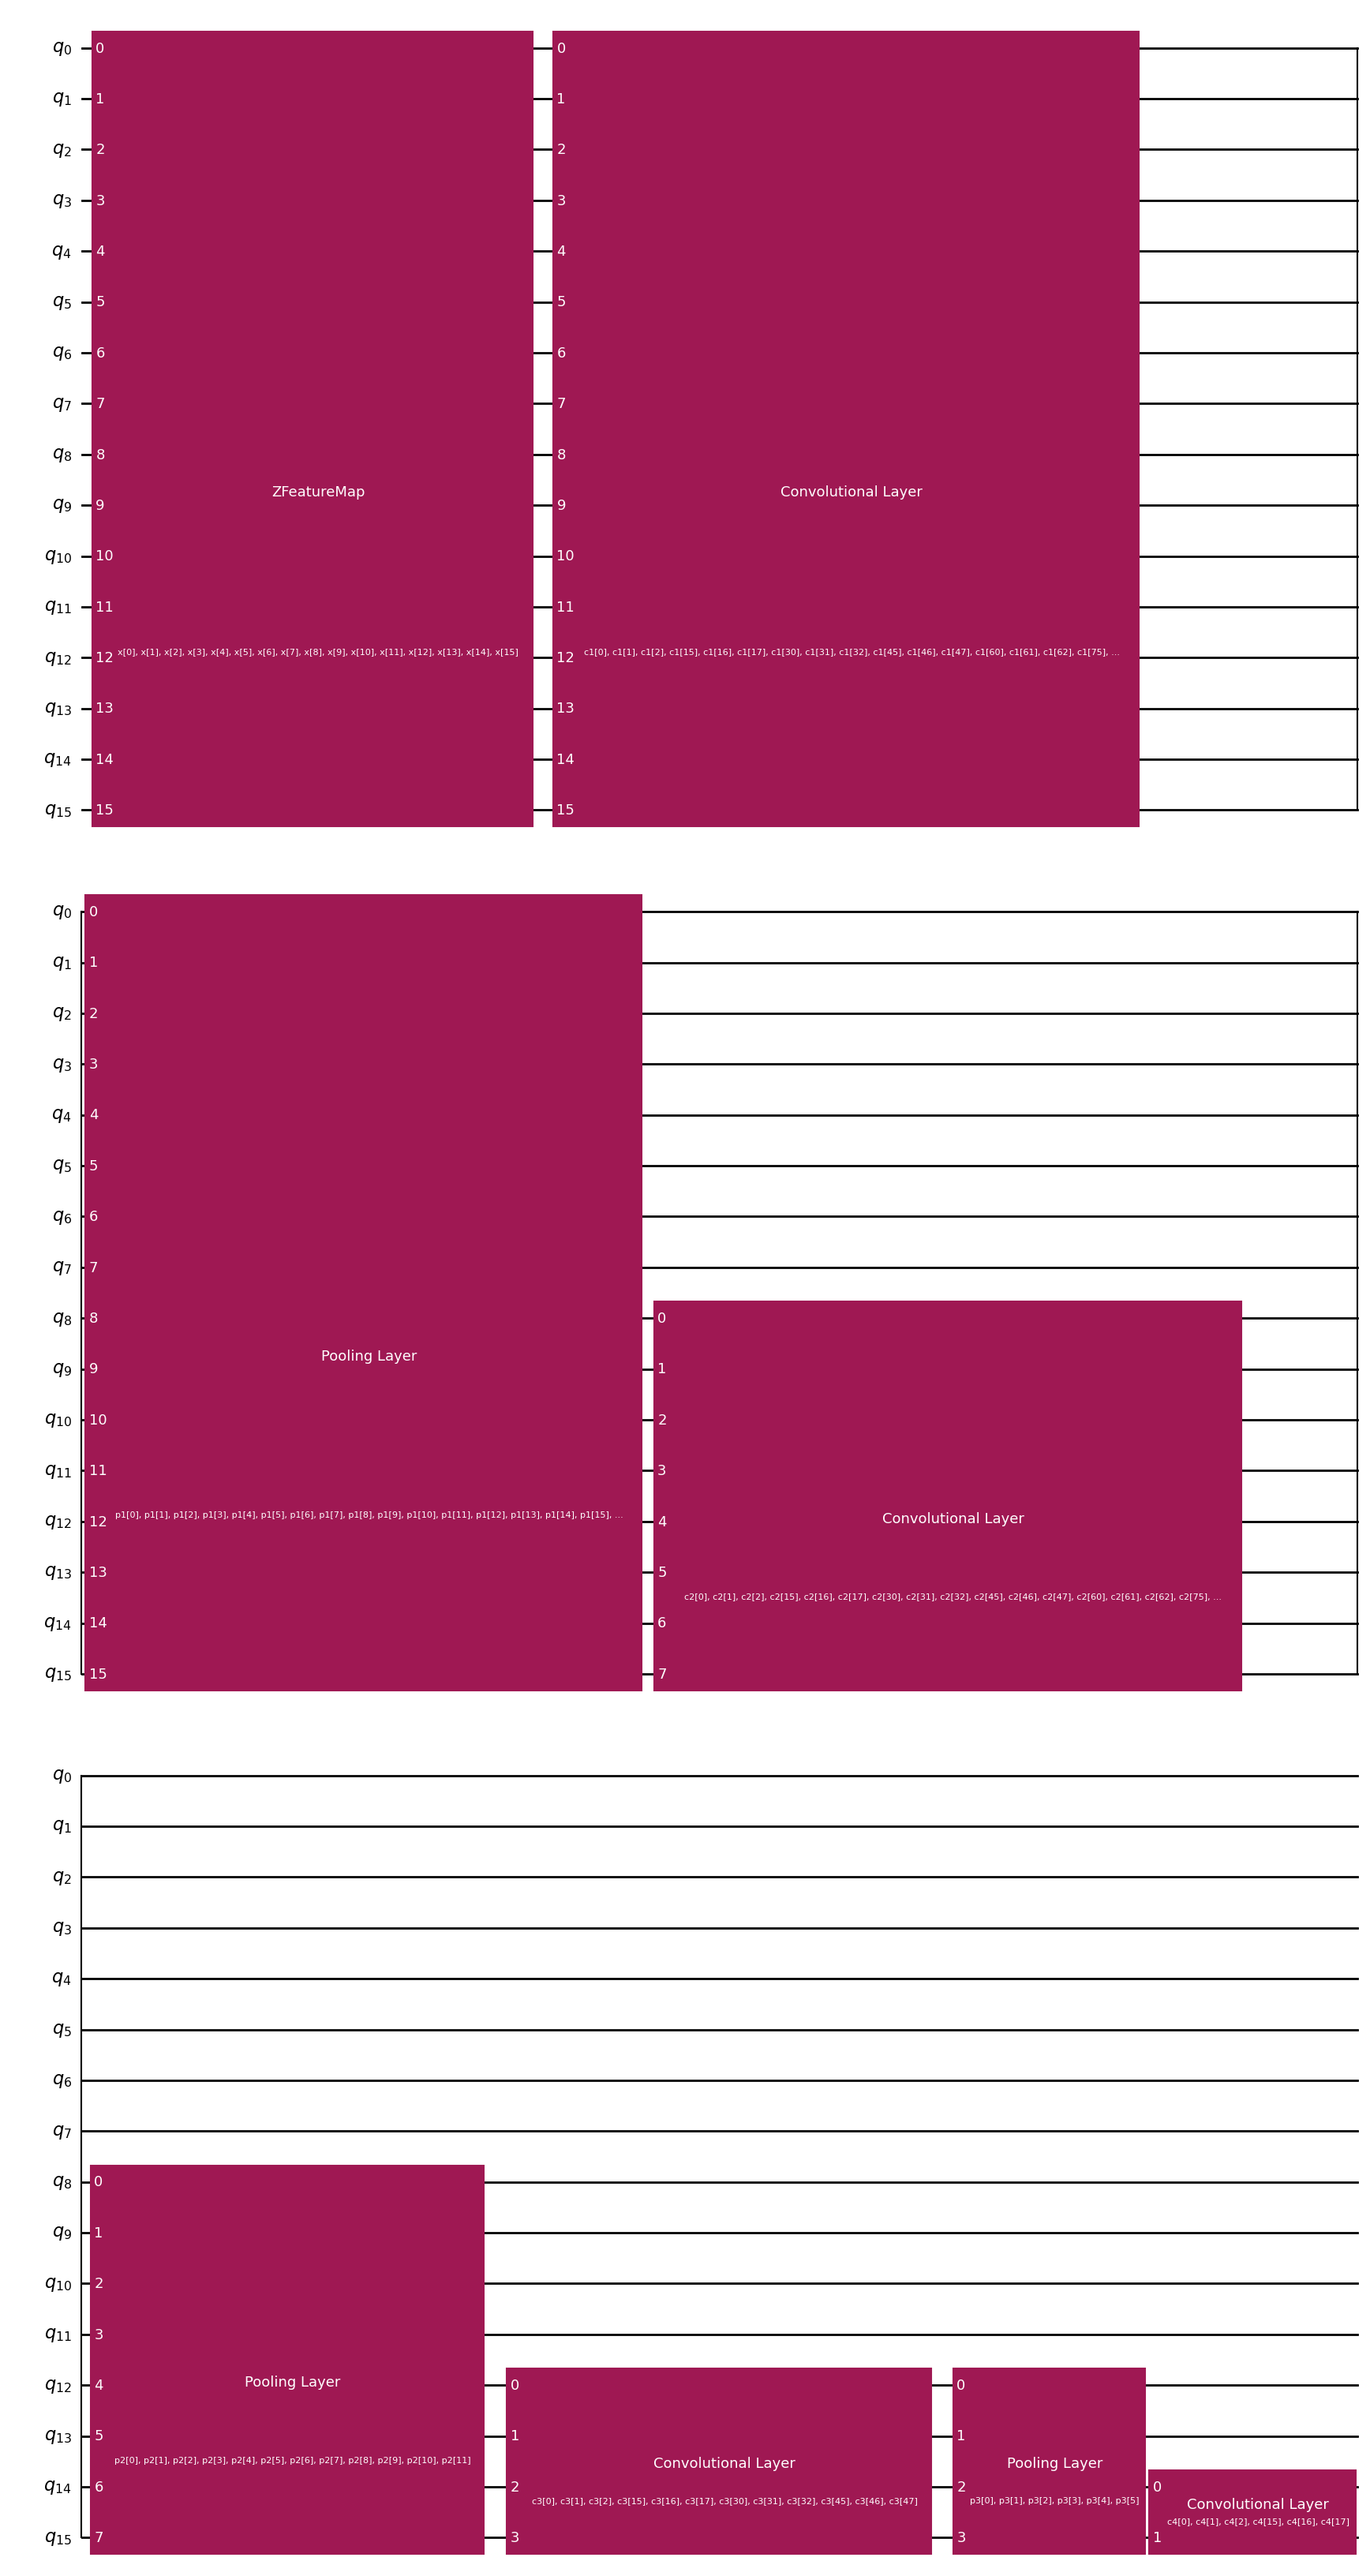

In [8]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    q_reg = QuantumRegister(16, "q_reg")
    ansatz = QuantumCircuit(q_reg, name="Ansatz")

    # First Convolutional Layer
    ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

    # First Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

    # Second Convolutional Layer
    ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

    # Second Pooling Layer
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

    # Third Convolutional Layer
    ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

    # Third Pooling Layer
    ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

    # Fourth Convolutional Layer
    ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    return circuit

# Visual
display(create_QCNN().draw("mpl"))

In [9]:
# Creating/Formatting Data

In [10]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-06 11:48:00.950484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733514480.964105   39178 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733514480.968671   39178 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 11:48:00.982790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [11]:
# Filter Values
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [12]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


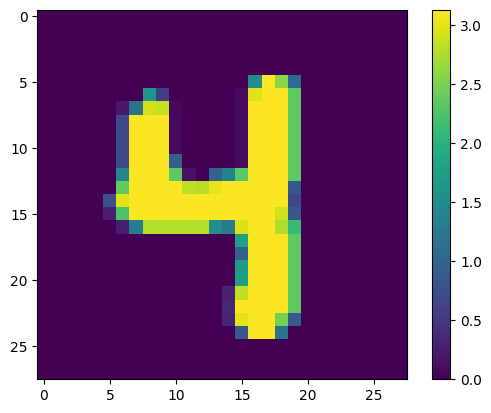

In [13]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [14]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1733514483.222967   39178 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


4


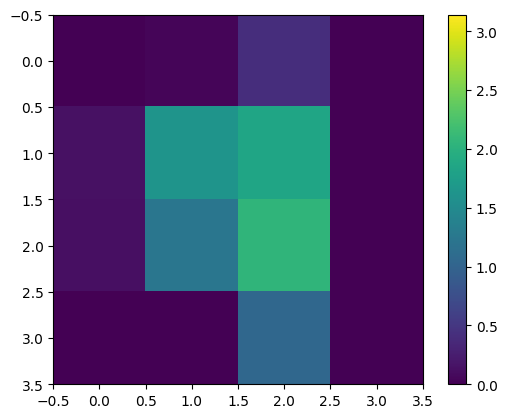

In [15]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [16]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
        elif entry == c:
            y_temp.append(2)
        elif entry == d:
            y_temp.append(3)
    return y_temp

In [17]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:100]
y = y[0:100]
x1 = x1[0:100]
y1 = y1[0:100]
print(x)
print(y)

[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.         0.45835322 0.4178733  ... 1.0285919  0.5543987  0.        ]
 [0.         0.         0.         ... 0.42139328 0.         0.        ]
 [0.         0.3017136  0.21145092 ... 0.60971284 0.7779182  0.        ]]
[1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0]


In [18]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
        elif y[i] == 2:
            countc+=1
        elif y[i] == 3:
            countd+=1
    return(counta, countb)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        elif y[i] == 2:
            if count2 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count2 += 1
        elif y[i] == 3:
            if count3 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [19]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (48, 52)
max_count = 48
balanced: (48, 48)
shuffled: (48, 48)
final: [[0.         0.47218174 0.         ... 0.         0.51567876 0.        ]
 [0.         0.50034165 0.5797929  ... 1.0135062  0.37965626 0.        ]
 [0.13702825 0.         0.3386735  ... 0.         0.4075648  0.18102817]
 ...
 [0.         0.49933597 0.25545081 ... 0.37839907 0.83624953 0.        ]
 [0.         0.40102762 1.1935287  ... 1.1517916  0.4430161  0.        ]
 [0.         0.24287944 0.02614851 ... 0.02564565 0.36281055 0.        ]]
[1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0
 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1
 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1]


In [20]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [21]:
# # Converting for -1 values.
# def convert(y):
#     tensor = tf.constant(y)
#     modified_tensor = tf.where(tensor == 0, -1, tensor).numpy()
#     modified_tensor = torch.from_numpy(modified_tensor)
#     return(modified_tensor)

In [22]:
# One-Hot Encoding for Final Processing
num_classes = 2
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [23]:
# Y = Y.to("cuda")
# Y1 = Y1.to("cuda")
print(X,Y,X1,Y1)

tensor([[0.0000, 0.4722, 0.0000,  ..., 0.0000, 0.5157, 0.0000],
        [0.0000, 0.5003, 0.5798,  ..., 1.0135, 0.3797, 0.0000],
        [0.1370, 0.0000, 0.3387,  ..., 0.0000, 0.4076, 0.1810],
        ...,
        [0.0000, 0.4993, 0.2555,  ..., 0.3784, 0.8362, 0.0000],
        [0.0000, 0.4010, 1.1935,  ..., 1.1518, 0.4430, 0.0000],
        [0.0000, 0.2429, 0.0261,  ..., 0.0256, 0.3628, 0.0000]],
       device='cuda:0') tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
  

In [24]:
# Training

In [25]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.qnn_module(x)
        x = self.softmax(x)
        return x

In [26]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

# Setting observables on 15th and 16th qubits.
observable_z16 = SparsePauliOp.from_sparse_list([("Z", [15], 1)], num_qubits=num_qubits)
observable_z15 = SparsePauliOp.from_sparse_list([("Z", [14], 1)], num_qubits=num_qubits)
observables = [observable_z15, observable_z16]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    observables = observables,
    input_gradients = True,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_39178/66135567.py:22: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_39178/66135567.py:22: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.07226562, -0.07421875],
       [ 0.08789062, -0.00195312],
       [ 0.125     ,  0.        ],
       [ 0.12109375, -0.03710938],
       [ 0.13867188, -0.05664062],
       [ 0.14453125, -0.01757812],
       [ 0.09179688, -0.09179688],
       [ 0.0546875 , -0.07421875],
       [ 0.1484375 , -0.015625  ],
       [ 0.07421875, -0.09179688],
       [ 0.109375  , -0.08984375],
       [-0.03320312,  0.03710938],
       [ 0.11523438, -0.0625    ],
       [ 0.046875  , -0.00585938],
       [ 0.04101562, -0.02148438],
       [ 0.11328125, -0.06054688],
       [ 0.12890625,  0.015625  ],
       [ 0.11328125, -0.00585938],
       [-0.00976562, -0.0859375 ],
       [ 0.16210938, -0.04492188],
       [ 0.05273438,  0.00195312],
       [ 0.0078125 , -0.01367188],
       [ 0.04492188, -0.08984375],
       [-0.01171875, -0.10742188],
       [-0.03515625, -0.04296875],
       [ 0.06054688, -0.05664062],
       [ 0.09375   , -0.05078125],
       [ 0.1015625 , -0.12304688],
       [ 0.12890625,

In [27]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [28]:
# We want to supply one-hot encoded labels.
from tensorflow.keras.losses import CategoricalCrossentropy
loss_func = CategoricalCrossentropy()

# Callback Helper Functions
def accuracy(output, Y):
    acc = 0
    for i in range(Y.size(dim=0)):
        val = output[i]
        if (torch.argmax(val) == torch.argmax(Y[i])):
            acc+=1
    return ((acc/(Y.size(dim=0)))*100)

def objective_function(weights):
    # Referencing Global Variables
    global data
    # Local Variable
    total_loss = 0.0
    # Overiding with new data
    model = Model(TorchConnector(estimator, weights)).to("cuda")
    # Getting Output
    output = model(X)
    loss_output = output.detach().cpu().numpy()
    loss_Y = Y.detach().cpu().numpy()
    # Calculate Loss
    loss = loss_func(loss_output, loss_Y).numpy()
    # Append Checkpoint Data Points to Tracker
    val = f"Iteration: {i}; Accuracy: {accuracy(output, Y)}%; Loss: {loss}"
    data.append(val)
    total_loss += loss
    loss_list.append(total_loss)
    return total_loss

def callback(weights):
    # Iteration Tracking
    global i
    global weight_list
    # Printing Checkpoint Data Points in Tracker
    print("\n".join(data))
    # Plotting Loss Function
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    plt.show()
    # Printing Weights
    weight_list.append(weights)
    print(weights)
    # Iteration Counter
    i+=1
    # Clearing Previous Graph/Weights
    clear_output(wait=True)

In [29]:
# Training Function
def fit(weights=None, list=None, iter= 100, fresh_start = False):
    global i
    global data
    global weight_list
    global loss_list
    if(fresh_start):
        loss_list = []
        data = []
        weight_list = []
        weights = algorithm_globals.random.random(estimator.num_weights)
        i = 1
    else:
        if weights is not None: weights = weights
        elif (('result' not in locals() and 'result' not in globals()) and ('weight_list' not in globals()) and 'weight_list' not in locals()) and weights == None:
            weights = algorithm_globals.random.random(estimator.num_weights)
        elif ('weight_list' in locals() or 'weight_list' in globals()):
            weights = weight_list[-1]
        else:
            weights = result[0].x
            loss_list = result[2]
        
        if 'data' not in globals(): data = []
        else: data = data
        if 'weight_list' not in globals():weight_list = []
        else: weight_list = weight_list
        if 'i' not in globals(): i = 1
        else: i = i
        if list is not None: list = list
        elif (('loss_list' not in globals() and 'loss_list' not in locals()) and list == None): loss_list = []
        elif 'loss_list' not in globals() and 'loss_list' not in locals(): loss_list = list
        else: loss_list = loss_list 
    
    result = minimize(
        fun=objective_function,
        callback = callback,
        x0=weights,
        method='COBYLA',
        options={'maxiter': iter},
    )
    return result, data, loss_list, weight_list

Iteration: 1; Accuracy: 45.83333333333333%; Loss: 8.167932510375977
Iteration: 2; Accuracy: 33.33333333333333%; Loss: 8.174882888793945
Iteration: 3; Accuracy: 36.45833333333333%; Loss: 8.161999702453613
Iteration: 4; Accuracy: 35.41666666666667%; Loss: 8.155043601989746
Iteration: 5; Accuracy: 34.375%; Loss: 8.158177375793457
Iteration: 6; Accuracy: 34.375%; Loss: 8.1563720703125
Iteration: 7; Accuracy: 34.375%; Loss: 8.158403396606445
Iteration: 8; Accuracy: 35.41666666666667%; Loss: 8.138894081115723
Iteration: 9; Accuracy: 44.79166666666667%; Loss: 8.113547325134277
Iteration: 10; Accuracy: 41.66666666666667%; Loss: 8.12984561920166
Iteration: 11; Accuracy: 36.45833333333333%; Loss: 8.16048812866211
Iteration: 12; Accuracy: 52.083333333333336%; Loss: 8.079497337341309
Iteration: 13; Accuracy: 52.083333333333336%; Loss: 8.065512657165527
Iteration: 14; Accuracy: 54.166666666666664%; Loss: 8.020415306091309
Iteration: 15; Accuracy: 50.0%; Loss: 8.084067344665527
Iteration: 16; Accura

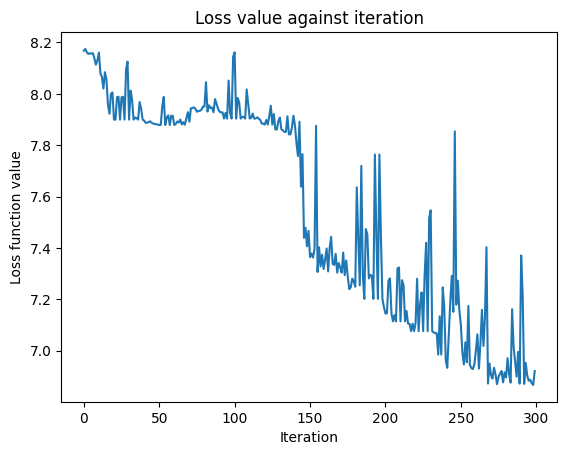

[0.63172361 2.49209173 2.32914787 3.55735305 1.12307718 1.72348133
 1.39706187 1.44672399 0.70257205 1.49862141 1.32043236 1.0646412
 1.71600046 0.85956121 2.34140811 1.25860132 1.74918629 0.40761999
 0.68617521 2.1430662  0.09711656 1.11075804 0.91008194 0.39484766
 0.62240973 0.43008119 0.71420574 1.35393461 1.76429022 0.6495414
 0.58984734 0.24783457 0.29157568 1.07255597 0.3587473  0.35289679
 0.44486682 0.59880434 0.43796341 1.00346126 1.38570967 0.83933351
 0.19241761 1.05518053 0.05764988 3.85835139 2.92660564 0.77604408
 2.95311414 1.97090794 0.49684037 0.01978453 0.55928612 0.56394347
 0.91638897 1.26310718 0.91559435 0.56277156 0.58833198 0.63658405
 3.17968303 2.94162533 0.51927569 1.69225469 1.0435184  0.52298519
 0.356233   0.37662747 1.82550415 2.93371931 1.42488814 0.28035201
 1.60260243 0.02792263 1.5274536  0.6495532  1.9004151  0.64521401
 1.83832043 0.62407466 1.98947882 0.04357371 0.46726381 1.71158005
 0.35070702 1.2839733  1.85588572 0.52445074 0.49768752 0.754351

In [33]:
# Call Training Function and Save as Result
result = fit(iter=129, fresh_start=False)

In [ ]:
savemodel = Model(TorchConnector(estimator, result[0].x))
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "Estimator2ClassesCircuit1SoftmaxFix100")

True


In [ ]:
evalmodel = torch.load("Estimator2ClassesCircuit1SoftmaxFix100", weights_only=False).to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 87.5%
Test Accuracy: 79.0%


In [36]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1,

In [37]:
print(result)

( message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 6.866209030151367
       x: [ 6.317e-01  2.492e+00 ...  3.134e-01  7.458e-01]
    nfev: 129
   maxcv: 0.0, ['Iteration: 1; Accuracy: 45.83333333333333%; Loss: 8.167932510375977', 'Iteration: 2; Accuracy: 33.33333333333333%; Loss: 8.174882888793945', 'Iteration: 3; Accuracy: 36.45833333333333%; Loss: 8.161999702453613', 'Iteration: 4; Accuracy: 35.41666666666667%; Loss: 8.155043601989746', 'Iteration: 5; Accuracy: 34.375%; Loss: 8.158177375793457', 'Iteration: 6; Accuracy: 34.375%; Loss: 8.1563720703125', 'Iteration: 7; Accuracy: 34.375%; Loss: 8.158403396606445', 'Iteration: 8; Accuracy: 35.41666666666667%; Loss: 8.138894081115723', 'Iteration: 9; Accuracy: 44.79166666666667%; Loss: 8.113547325134277', 'Iteration: 10; Accuracy: 41.66666666666667%; Loss: 8.12984561920166', 'Iteration: 11; Accuracy: 36.45833333333333%; Loss: 8.16048812866211', 'Iteration: 12; Accuracy: 52.0833333333

In [38]:
result[1]

['Iteration: 1; Accuracy: 45.83333333333333%; Loss: 8.167932510375977',
 'Iteration: 2; Accuracy: 33.33333333333333%; Loss: 8.174882888793945',
 'Iteration: 3; Accuracy: 36.45833333333333%; Loss: 8.161999702453613',
 'Iteration: 4; Accuracy: 35.41666666666667%; Loss: 8.155043601989746',
 'Iteration: 5; Accuracy: 34.375%; Loss: 8.158177375793457',
 'Iteration: 6; Accuracy: 34.375%; Loss: 8.1563720703125',
 'Iteration: 7; Accuracy: 34.375%; Loss: 8.158403396606445',
 'Iteration: 8; Accuracy: 35.41666666666667%; Loss: 8.138894081115723',
 'Iteration: 9; Accuracy: 44.79166666666667%; Loss: 8.113547325134277',
 'Iteration: 10; Accuracy: 41.66666666666667%; Loss: 8.12984561920166',
 'Iteration: 11; Accuracy: 36.45833333333333%; Loss: 8.16048812866211',
 'Iteration: 12; Accuracy: 52.083333333333336%; Loss: 8.079497337341309',
 'Iteration: 13; Accuracy: 52.083333333333336%; Loss: 8.065512657165527',
 'Iteration: 14; Accuracy: 54.166666666666664%; Loss: 8.020415306091309',
 'Iteration: 15; Accu